# Proglearn: Scene Segmentation of ISIC using Scikit-Image
*Neuro Data Design II: Spring 2022*


This tutorial provides a walkthrough to applying a Random Forest model to perform scene segmentation on images taken from the International Skin Imaging Collaboration (ISIC) dataset from 2016 using Scikit-Image. 


**Contributor**: Amy van Ee (avanee1@jhu.edu)

## I. Preprocessing of Images

In this first section, we will import our images from the ISIC dataset and familiarize ourselves with this dataset.

In [1]:
# ========================================================#
# import packages

# for handling the dataset
import cv2
import os

# for processing the dataset and visualization
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray

# for scene segmentation
from skimage import segmentation, feature, future
from sklearn.ensemble import RandomForestClassifier
from functools import partial

# original functions for scene segmentation
from functions.scene_segmentation_rf_isic_exp_functions import (
    get_dice,
    perform_scene_seg,
)

# for analyzing scene segmentation performance
from skimage.metrics import adapted_rand_error, variation_of_information

In [2]:
# ========================================================#
# retrieve data

# input location of data
dataloc = "C:/Users/Amy/Documents/Python/Neuro Data Design/"

# extract images
datalbl = dataloc + "NDD II/ISIC/ISBI2016_ISIC_Part1_Training_GroundTruth/"
dataimg = dataloc + "NDD II/ISIC/ISBI2016_ISIC_Part1_Training_Data/"

lblpaths = [datalbl + im for im in os.listdir(datalbl)]
imgpaths = [dataimg + im for im in os.listdir(dataimg)]

# sort and print information
imgpaths.sort()
lblpaths.sort()
print("Total # of images =", len(imgpaths))
print("Total # of labels =", len(lblpaths))

Total # of images = 1279
Total # of labels = 1279


In [3]:
# ========================================================#
# load all images
images = [cv2.imread(img) for img in imgpaths]
labels_grey = np.array(
    [(rgb2gray(cv2.imread(lblpath)) * 1000).astype(int) for lblpath in lblpaths]
)

# get dimensions of dataset
xdim_images = [np.shape(img)[1] for img in images]
ydim_images = [np.shape(img)[0] for img in images]

xdim_labels = [np.shape(lbl)[1] for lbl in labels_grey]
ydim_labels = [np.shape(lbl)[0] for lbl in labels_grey]

C:\Users\Amy\AppData\Local\Temp\ipykernel_74052\957590051.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  labels_grey = np.array(


**Visualize an Example Image**

We will choose a sample image from the ISIC dataset to see the original image adjacent to the annotated image.

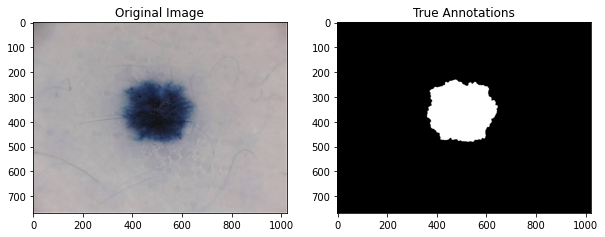

In [4]:
# ========================================================#
# Plot the original image alongside the annotated image

# Prepare plot
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 10)

# import image 1
image = cv2.imread(imgpaths[1])
# import annotation for image 1 and convert to greyscale
label_grey = (rgb2gray(cv2.imread(lblpaths[1])) * 1000).astype(int)

# plot data
ax[0].imshow(image)
ax[0].set_title("Original Image")
ax[1].imshow(label_grey, cmap=plt.cm.gray)
ax[1].set_title("True Annotations")
plt.show()

## II. Scene Segmentation using Scikit

Having familiarized ourself with the images after some analysis, we will now proceed to perform scene segmentation.

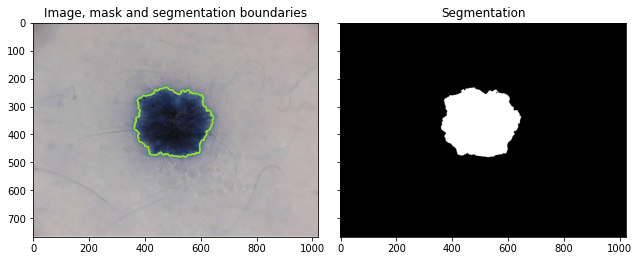

In [5]:
# ========================================================#
# Use scikit-image to perform Image Segmentation

# prepare training labels to train the model
training_labels = np.zeros(image.shape[:2], dtype=np.uint8)
training_labels = np.add(label_grey, training_labels)
training_labels[training_labels == 0] = 1

# perform training
sigma_min = 1
sigma_max = 16
features_func = partial(
    feature.multiscale_basic_features,
    intensity=True,
    edges=False,
    texture=True,
    sigma_min=sigma_min,
    sigma_max=sigma_max,
    channel_axis=-1,
)

# obtain features from image
features = features_func(image)

# define random forest
clf = RandomForestClassifier(n_estimators=50, n_jobs=-1, max_depth=10, max_samples=0.05)

# fit forest to features from original image and labeled image
clf = future.fit_segmenter(training_labels, features, clf)

# predict labels after training
# result will be array of 1's (normal) and 1000's (lesion)
result = future.predict_segmenter(features, clf)

# plot results
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 4))
ax[0].imshow(segmentation.mark_boundaries(image, result, mode="thick"))
ax[0].contour(training_labels)
ax[0].set_title("Image, mask and segmentation boundaries")
ax[1].imshow(result, cmap=plt.cm.gray)
ax[1].set_title("Segmentation")
fig.tight_layout()

**Analyzing Accuracy**

We will next analyze the performance of scikit-image by computing the accuracy. We will do so by comparing the result from scene segmentation to the true annotated image.

Adapted Rand error: 0.010236420635643673
Adapted Rand precision: 0.9797346038480717
Adapted Rand recall: 1.0
False Splits: 0.014077421463033514
False Merges: 0.014000413943693838
Dice Coefficient: 0.9985839560949846


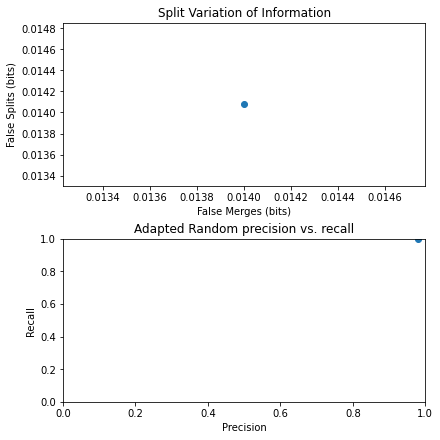

In [6]:
# ========================================================#
# Analyze the accuracy by looking at
# precision, recall, false splits, false merges, dice score

# correction so that the "normal" label for the predicted
# array matches that of the true array (both "0")
result[result == 1] = 0

# calculate error, precision, recall, splits, merges, dice
error, precision, recall = adapted_rand_error(label_grey, result)
splits, merges = variation_of_information(label_grey, result)
dice = get_dice(label_grey, result)

# print results
print(f"Adapted Rand error: {error}")
print(f"Adapted Rand precision: {precision}")
print(f"Adapted Rand recall: {recall}")
print(f"False Splits: {splits}")
print(f"False Merges: {merges}")
print(f"Dice Coefficient: {dice}")

# create figure to show results
fig, axes = plt.subplots(2, 1, figsize=(6, 6), constrained_layout=True)
ax = axes.ravel()

# plot merges and splits
ax[0].scatter(merges, splits)
ax[0].set_xlabel("False Merges (bits)")
ax[0].set_ylabel("False Splits (bits)")
ax[0].set_title("Split Variation of Information")

# plot preicision and recall
ax[1].scatter(precision, recall)
ax[1].set_xlabel("Precision")
ax[1].set_ylabel("Recall")
ax[1].set_title("Adapted Random precision vs. recall")
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 1)

plt.show()

Evidently, it appears that scikit-image did a good job of scene segmentation, and so we next test it on other images in the dataset.

**Testing the Model**

We will now predict the scene segmentation for a few other images and look at the visual output.

Adapted Rand error: 0.3265655380964795
Adapted Rand precision: 0.5076526131304809
Adapted Rand recall: 1.0
False Splits: 0.5531410008994508
False Merges: 0.680342713046319
Dice Coefficient: 0.8188994659856048


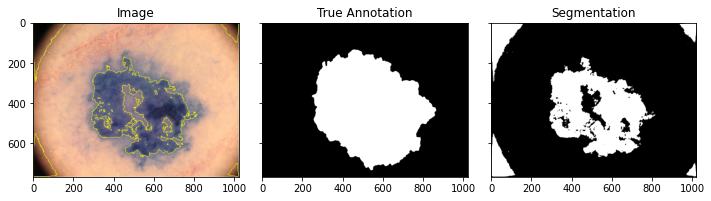

In [30]:
# ========================================================#
# perform scene segmentation on a third image

perform_scene_seg(images[2], labels_grey[2], clf)

In [36]:
# ========================================================#
# learn about structure of posteriors
sh = features.shape
if features.ndim > 2:
    features = features.reshape((-1, sh[-1]))
try:
    predicted_labels = clf.predict(features)
    predicted_proba = clf.predict_proba(features)
except NotFittedError:
    raise NotFittedError(
        "You must train the classifier `clf` first"
        "for example with the `fit_segmenter` function."
    )
except ValueError as err:
    if err.args and 'x must consist of vectors of length' in err.args[0]:
        raise ValueError(
            err.args[0] + '\n' +
            "Maybe you did not use the same type of features for training the classifier."
            )
    else:
        raise err
output = predicted_labels.reshape(sh[:-1])
#output_proba = predicted_proba.reshape(sh[:-1])


In [32]:
output.shape

(783874,)

In [33]:
predicted_proba.shape

(783874, 2)

In [34]:
np.unique(predicted_proba)

array([0.00000000e+00, 3.63636364e-04, 3.92156863e-04, ...,
       9.99607843e-01, 9.99636364e-01, 1.00000000e+00])

Adapted Rand error: 0.28898841692624044
Adapted Rand precision: 0.5516043230002474
Adapted Rand recall: 1.0
False Splits: 0.307387447327057
False Merges: 0.4652813994844845
Dice Coefficient: 0.8871285436179794


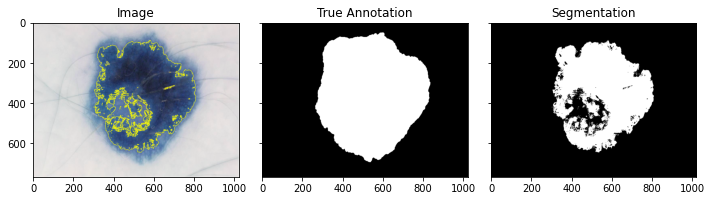

In [12]:
# ========================================================#
# perform scene segmentation on a third image

perform_scene_seg(images[3], labels_grey[3], clf)

Adapted Rand error: 0.2919986605281044
Adapted Rand precision: 0.5479892209659877
Adapted Rand recall: 1.0
False Splits: 0.3219221617565031
False Merges: 0.4501672997003304
Dice Coefficient: 0.9058509403296958


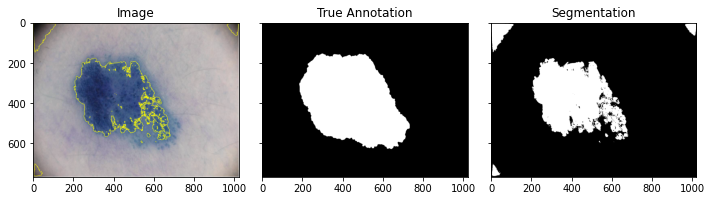

In [13]:
# ========================================================#
# perform scene segmentation on a third image

perform_scene_seg(images[8], labels_grey[8], clf)

**Testing the Model on 100 Images**

We will know look at the accuracy of the model after performing scene segmentation on 100 images.

In [14]:
# ========================================================#
# perform scene segmentation on 100 images

n = 100

# initialize arrays
error_list = np.zeros(n)
precision_list = np.zeros(n)
recall_list = np.zeros(n)
splits_list = np.zeros(n)
merges_list = np.zeros(n)
dice_list = np.zeros(n)
result_list = np.zeros(n, dtype=object)

# loop through each image and determine values
for i in np.arange(len(images[1:n])):
    # use classifier
    features = features_func(images[i])
    result = future.predict_segmenter(features, clf)
    result[result == 1] = 0  # correction for when compare to true

    # assess
    error, precision, recall = adapted_rand_error(labels_grey[i], result)
    splits, merges = variation_of_information(labels_grey[i], result)
    dice = get_dice(labels_grey[i], result)

    # add to list
    error_list[i] = error
    precision_list[i] = precision
    recall_list[i] = recall
    splits_list[i] = splits
    merges_list[i] = merges
    dice_list[i] = dice
    result_list[i] = result

Text(0.5, 1.0, 'Histogram of Dice Coefficients')

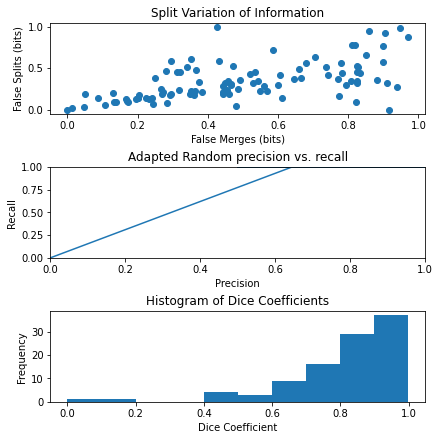

In [15]:
# ========================================================#
# analyze results

# create figure
fig, axes = plt.subplots(3, 1, figsize=(6, 6), constrained_layout=True)
ax = axes.ravel()

# plot merges, splits
ax[0].scatter(merges_list, splits_list)
ax[0].set_xlabel("False Merges (bits)")
ax[0].set_ylabel("False Splits (bits)")
ax[0].set_title("Split Variation of Information")

# plot precision, recall
ax[1].plot(precision_list, recall_list)
ax[1].set_xlabel("Precision")
ax[1].set_ylabel("Recall")
ax[1].set_title("Adapted Random precision vs. recall")
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 1)

# plot dice coefficients
ax[2].hist(dice_list)
ax[2].set_xlabel("Dice Coefficient")
ax[2].set_ylabel("Frequency")
ax[2].set_title("Histogram of Dice Coefficients")

## III. Conclusion

Evidently, we can see that Scikit-Image works well to perform scene-segmentation of images, but it is not perfect, and there is still great room for improvement in applying machine learning to perform scene segmentation.

## IV. Implementation of ProgLearn

In [ ]:
from proglearn import LifeLongClassificationForest

# set up
progtree = LifeLongClassificationForest()
progtree.add_task(images[0:10], labels_grey[0:10])

# test
prediction = progtree.predict(images[11:20], task_id = 0)
prediction_proba = progtree.predict_proba(images[11:20], task_id = 0)